# Car Price prediction

<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам
*Этот ноутбук является шаблоном (Baseline) к текущему соревнованию и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.


> **Baseline** создается больше как шаблон, где можно посмотреть, как происходит обращение с входящими данными и что нужно получить на выходе. При этом ML начинка может быть достаточно простой. Это помогает быстрее приступить к самому ML, а не тратить ценное время на инженерные задачи. 
Также baseline является хорошей опорной точкой по метрике. Если наше решение хуже baseline -  мы явно делаем что-то не так и стоит попробовать другой путь) 

## В baseline мы сделаем следующее:
* Построим "наивную"/baseline модель, предсказывающую цену по модели и году выпуска (с ней будем сравнивать другие модели)
* Обработаем и отнормируем признаки
* Сделаем первую модель на основе градиентного бустинга с помощью CatBoost
* Сделаем вторую модель на основе нейронных сетей и сравним результаты
* Сделаем multi-input нейронную сеть для анализа табличных данных и текста одновременно
* Добавим в multi-input сеть обработку изображений
* Осуществим ансамблирование градиентного бустинга и нейронной сети (усреднение их предсказаний)

In [1]:
!pip install -q tensorflow==2.3

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
#аугментации изображений
!pip install albumentations -q

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
# Импортируем библиотеки

import pandas as pd # импортируем необходимые библиотеки
import numpy as np
import re
import random
import os
import sys
import PIL
import cv2

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import ExtraTreeRegressor
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler 

from catboost import CatBoostRegressor

from tqdm import tqdm
from tqdm.notebook import tqdm

from itertools import combinations
from scipy.stats import ttest_ind


# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
#import albumentations

import nltk
from nltk.corpus import stopwords

# plt
import matplotlib.pyplot as plt
import seaborn as sns
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

In [4]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0


In [5]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [6]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [7]:
!pip freeze > requirements.txt

# DATA

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [8]:
# Загрузим данные, в том числе предобработанный датасет

DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train1 = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')
train = pd.read_csv('../input/edatrain/train_batmobil7.csv')

In [9]:
# копия с description пригодится нам позже

data = train.copy()

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              8353 non-null   object
 1   brand                 8353 non-null   object
 2   color                 8353 non-null   object
 3   description           8353 non-null   object
 4   engineDisplacement    8353 non-null   int64 
 5   enginePower           8353 non-null   int64 
 6   fuelType              8353 non-null   object
 7   mileage               8353 non-null   int64 
 8   modelDate             8353 non-null   int64 
 9   model_info            8353 non-null   object
 10  name                  8353 non-null   object
 11  numberOfDoors         8353 non-null   int64 
 12  productionDate        8353 non-null   int64 
 13  sell_id               8353 non-null   int64 
 14  vehicleConfiguration  8353 non-null   object
 15  vehicleTransmission   8353 non-null   

In [11]:
train.nunique()

bodyType                  17
brand                      3
color                     16
description             7654
engineDisplacement        48
enginePower              154
fuelType                   4
mileage                 3507
modelDate                 43
model_info               122
name                     976
numberOfDoors              4
productionDate            39
sell_id                 8353
vehicleConfiguration     312
vehicleTransmission        4
Владельцы                  3
Владение                 187
ПТС                        2
Привод                     3
Руль                       2
sample                     2
price                   1629
mil_year                4217
pow_eng                   20
Владение_год              68
Владение_мес              12
Owner_year                72
name1                    228
name2                      6
tax                      154
dtype: int64

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [12]:
# split данных
data_train, data_test = train_test_split(train1, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [13]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


# EDA

EDA выполнен в отдельном ноутбке, здесь проведем удаление ненужных столбцов и предобработку.

In [14]:
# Удалим лишние столбцы

#data = train.copy()

train = train.drop(['vehicleConfiguration', 'sell_id', 'Владение_мес', 'Владение_год', 'Руль', 'modelDate', 'description', 'name'], axis = 1)  
#train = train.drop(['description'], axis = 1) 

In [15]:
#используем все текстовые признаки как категориальные без предобработки
categorical_features = [ 'bodyType', 'brand', 'color',  'fuelType', 'model_info', 'name1','name2','numberOfDoors',  'vehicleTransmission',
       'Владельцы', 'ПТС', 'Привод']

#используем все числовые признаки
numerical_features = ['engineDisplacement', 'enginePower', 'mileage', 'productionDate', 'Владение', 'mil_year','Owner_year', 'pow_eng', 'tax']

# 'price',

Итого:
* CatBoost сможет работать с признаками и в таком виде, но для нейросети нужны нормированные данные.

# PreProc Tabular Data

In [16]:
print(train1.shape, test.shape, train.shape)

(6682, 22) (1671, 21) (8353, 23)


In [17]:
def preproc_data(df_input):
   
    df_output = df_input.copy()

    # Нормализация данных
    scaler =  StandardScaler() # MinMaxScaler() #StandardScaler() 
    for column in numerical_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]

#    for column in numerical_features:
#        df_output[column] = np.log(df_output[[column]])

    # ################### Categorical Features ############################################################## 
    # Label Encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes
        
    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(df_output, columns=categorical_features, dummy_na=False)

    return df_output

In [18]:
# Запускаем предобработку данных и проверяем, что получилось

df_preproc = preproc_data(train)
df_preproc.sample(10)

,engineDisplacement,enginePower,mileage,productionDate,Владение,sample,price,mil_year,pow_eng,Owner_year,...,vehicleTransmission_2,vehicleTransmission_3,Владельцы_0,Владельцы_1,Владельцы_2,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2
7399,-0.734689,-0.096990,-0.163258,-0.585318,0.199809,1,1590000,0.647170,1.513721,0.382961,...,0,0,1,0,0,0,1,0,0,1
4273,-0.734689,-0.096990,-0.920726,-0.781128,-0.578617,1,3100000,-0.539054,1.513721,0.006881,...,0,0,1,0,0,0,1,0,0,1
3362,2.572827,3.025790,-0.798553,-0.585318,-0.866922,1,3750000,-0.568271,0.967492,-0.870640,...,0,0,0,0,1,0,1,0,0,1
2794,0.210315,-0.096990,0.056651,0.197919,-0.405633,1,1990000,-0.230635,-0.671195,-0.369199,...,0,1,0,0,1,0,1,0,0,1
5378,-0.734689,-0.344976,0.349864,-0.585318,-0.866922,1,1285000,1.628873,0.967492,-0.870640,...,0,0,0,0,1,0,1,0,0,1
5902,1.155320,2.796174,-0.617739,-0.193700,0.978234,1,3399999,-0.688530,2.606179,1.135122,...,0,0,1,0,0,0,1,0,0,1
1454,0.210315,0.591858,-0.825847,-0.585318,-0.578617,0,0,-0.620512,0.967492,-0.557239,...,0,0,0,1,0,0,1,0,0,1
2476,-0.262187,-0.344976,0.649186,0.785347,-0.232650,1,700000,-0.164137,-0.124966,0.006881,...,0,0,0,0,1,1,0,1,0,0
743,-1.112691,-1.290995,-0.004435,0.393728,-0.290311,0,0,-0.451402,-1.217424,-0.243839,...,0,0,0,0,1,0,1,1,0,0
1168,2.572827,2.649220,-1.030680,-0.389509,-0.751600,0,0,-1.152618,0.421263,-0.745280,...,0,0,0,0,1,0,1,0,0,1


In [19]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Columns: 423 entries, engineDisplacement to Привод_2
dtypes: float64(9), int64(2), uint8(412)
memory usage: 4.0 MB


## Split data

In [20]:
# Теперь выделим тестовую часть

train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = (train_data.price.values)     # наш таргет np.log
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [21]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1671 entries, 0 to 1670
Columns: 422 entries, engineDisplacement to Привод_2
dtypes: float64(9), int64(1), uint8(412)
memory usage: 815.9 KB


# Model 2: CatBoostRegressor

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [23]:
model = CatBoostRegressor(iterations = 7000,
                          #depth=10,
                          learning_rate = 0.1,   # 0.1 лучший рез-т
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=800,
                          #task_type='GPU',
                         )
model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         plot=True
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9315266	test: 0.9545553	best: 0.9545553 (0)	total: 56.6ms	remaining: 6m 36s
100:	learn: 0.1848801	test: 0.1874065	best: 0.1874065 (100)	total: 511ms	remaining: 34.9s
200:	learn: 0.1554620	test: 0.1618580	best: 0.1618580 (200)	total: 1.28s	remaining: 43.4s
300:	learn: 0.1416054	test: 0.1535253	best: 0.1534156 (298)	total: 2.08s	remaining: 46.3s
400:	learn: 0.1301653	test: 0.1458446	best: 0.1458446 (400)	total: 2.53s	remaining: 41.6s
500:	learn: 0.1229534	test: 0.1418816	best: 0.1418816 (500)	total: 2.98s	remaining: 38.7s
600:	learn: 0.1167714	test: 0.1386573	best: 0.1386573 (600)	total: 3.49s	remaining: 37.1s
700:	learn: 0.1123344	test: 0.1368709	best: 0.1368709 (700)	total: 3.96s	remaining: 35.6s
800:	learn: 0.1082873	test: 0.1355548	best: 0.1355385 (797)	total: 4.65s	remaining: 36s
900:	learn: 0.1046205	test: 0.1339305	best: 0.1338998 (886)	total: 5.1s	remaining: 34.5s
1000:	learn: 0.1014002	test: 0.1330977	best: 0.1330444 (993)	total: 5.66s	remaining: 33.9s
1100:	learn: 0

In [24]:
test_predict_catboost = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")

TEST mape: 12.74%


### Submission по результатам catboost

In [25]:
sub_predict_catboost = model.predict(X_sub)
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('catboost_submission11.csv', index=False)

# Model 3: Tabular NN

Построим обычную сеть:

In [26]:
X_train.head(5)

,engineDisplacement,enginePower,mileage,productionDate,Владение,mil_year,pow_eng,Owner_year,tax,bodyType_0,...,vehicleTransmission_2,vehicleTransmission_3,Владельцы_0,Владельцы_1,Владельцы_2,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2
7320,3.045329,2.649220,0.362082,0.197919,1.785490,0.094028,-0.124966,1.887283,2.356291,0,...,0,0,1,0,0,0,1,1,0,0
8037,-0.734689,-0.096990,-1.214647,-1.172746,-0.751600,-0.630095,1.513721,-0.745280,-0.359217,0,...,0,0,1,0,0,0,1,0,0,1
4681,0.304816,-0.005144,0.165348,1.176966,0.170978,-0.736095,-0.671195,0.257601,0.494412,0,...,0,0,0,0,1,0,1,0,0,1
6014,-0.923690,-0.657254,2.561180,0.981157,0.834081,1.112895,0.421263,0.132241,-0.713769,0,...,0,0,0,0,1,0,1,1,0,0
3649,0.210315,0.527566,0.068869,-0.193700,0.805251,0.249814,0.421263,1.135122,0.868076,0,...,0,0,1,0,0,0,1,0,0,1


## Simple Dense NN

In [27]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(L.Dropout(0.8))
model.add(L.Dense(286, activation="relu"))
model.add(L.Dropout(0.6))
model.add(L.Dense(1, activation="linear"))

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               216064    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 286)               146718    
_________________________________________________________________
dropout_1 (Dropout)          (None, 286)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 287       
Total params: 363,069
Trainable params: 363,069
Non-trainable params: 0
_________________________________________________________________


In [29]:
# Compile model

optimizer = tf.keras.optimizers.Adam(0.008)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [30]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=100, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

### Fit

In [31]:
history = model.fit(X_train, y_train,
                    batch_size=256,
                    epochs=1000, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0,
                   )

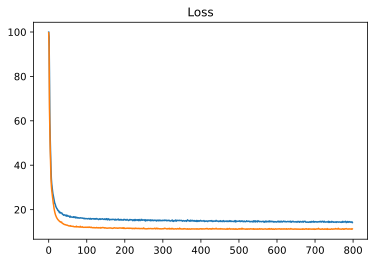

In [32]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [33]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_1.hdf5')

In [34]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 11.31%


In [35]:
sub_predict_nn1 = model.predict(X_sub)
sub_predict_nn1[:,0]


array([ 681059.2, 2610983.8,  632699.9, ..., 1535833.5, 1148030.2,
       1091997.8], dtype=float32)

In [36]:
sample_submission['price'] = (sub_predict_nn1[:,0]) #np.exp
sample_submission.to_csv('nn1_submission10.csv', index=False)

# **Model 4: NLP + Multiple Inputs**

In [37]:
#data = train.copy()

In [38]:
# Поработаем с текстом

data.description

0       Всем привет!\n\nПродам эксклюзивный проект 124...
1       Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...
2       Машина тут продаётся не в первый раз, НО! Толь...
3       Автомобиль в отличном состоянии, весь в родной...
4       Немка! с бесключивым доступом и камерой заднег...
                              ...                        
8348    Продаётся любимый автомобиль! За годы эксплуат...
8349    Куплена у официального дилера в 2017 г. \n\nТр...
8350    Торг на месте. Все работает. Сборка немецкая. ...
8351    Автомобиль в отличном состоянии.\n3-из Авто в ...
8352    Удлиненный заводской Pullman на базе W140 (воо...
Name: description, Length: 8353, dtype: object

In [39]:
# загрузка стоп слов

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = stopwords.words("russian")
stopwords

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['и',
 'в',
 'во',
 'не',
 'что',
 'он',
 'на',
 'я',
 'с',
 'со',
 'как',
 'а',
 'то',
 'все',
 'она',
 'так',
 'его',
 'но',
 'да',
 'ты',
 'к',
 'у',
 'же',
 'вы',
 'за',
 'бы',
 'по',
 'только',
 'ее',
 'мне',
 'было',
 'вот',
 'от',
 'меня',
 'еще',
 'нет',
 'о',
 'из',
 'ему',
 'теперь',
 'когда',
 'даже',
 'ну',
 'вдруг',
 'ли',
 'если',
 'уже',
 'или',
 'ни',
 'быть',
 'был',
 'него',
 'до',
 'вас',
 'нибудь',
 'опять',
 'уж',
 'вам',
 'ведь',
 'там',
 'потом',
 'себя',
 'ничего',
 'ей',
 'может',
 'они',
 'тут',
 'где',
 'есть',
 'надо',
 'ней',
 'для',
 'мы',
 'тебя',
 'их',
 'чем',
 'была',
 'сам',
 'чтоб',
 'без',
 'будто',
 'чего',
 'раз',
 'тоже',
 'себе',
 'под',
 'будет',
 'ж',
 'тогда',
 'кто',
 'этот',
 'того',
 'потому',
 'этого',
 'какой',
 'совсем',
 'ним',
 'здесь',
 'этом',
 'один',
 'почти',
 'мой',
 'тем',
 'чтобы',
 'нее',
 'сейчас',
 'были',
 'куда',
 'зачем',
 'всех',
 'никогда',
 'можно',
 'при',
 'наконец',
 'два',
 'об',
 'другой',
 'хоть',
 'после',
 'на

In [40]:
# Дополним список СТОП слов (можно добавить любые слова):

stopwords_add = list(set(['что', '000', '00', '3', '2', 'й','r19', 'это', '[smart]', 'также', '2017', 'вот', 'быть', 'как', 'в', '•', 'и', 'с', 'на', 'не', 'по', 'все', 'для', 'от', 'в', 'до', 'при', 'у','пр','на','для','б','———————————————————————————', 'о','тот', 'этот',
 '2', 'без', 'за','то', 'есть', '1', 'года', 'только', '6', 'км', 'лет', '3', 'а', 'мы', '9' , 'вас', '5', '–', 'м', '∙', 'я', 'ваш', '4', 'вы', '7', 'm', 'к', '00', 'год', '10', '8', '—',  'ii', 'gt', '❤️', 'др' , 'м', '5', '6', '9', '2', 'hegcedh',          
 'л', 'всех', 'in', 'о', 'т', 'же', 'ни',  'под', 'можете', 'была', 'д', 'тыс', '0', 's', 'час', 'вся', 'всё', 'наш', 'г', '30', '11', 'если', 'возможна', 'это', 'себя', '☑️', 'нам', '50',  'ин', 'c', 'во', '✔',
 'х', '➥', '40', 'ряд', 'этого', '2018', '13', '●', 'эл', 'ти', '25', 'могу', '01', 'fi', '·', '2014', '✅', 'ещё','й', 'б', 'позвоните', '72', 'гк', 'сел', '03811', 'uy07066', 'в','v', '3', 'и','а', 'я','вы', 'нет', 'тем',
 'поехал', 'ооо', '☛', 'раз', 'i','bmw', 'км', 'с', 'amg' '60', '«гарантия', 'р', 'кто', 'тд', '2013', 'мне', 'там', 'информации', '2016', 'лицо', 'еще',  '2012', 'оф', 'л'
 ]))
stopwords.extend (stopwords_add)

In [41]:
# Преобразуем все слова к маленьким буквам

data['description'] = data['description'].apply(lambda s: s.lower())

In [42]:
def filter_str(st):
# Фильтруем стоп-слова в Desrciption:

    split_str = st.split()
    filtered_str = ' '.join((filter(lambda s: s not in stopwords, split_str)))
    return filtered_str

data['description_filtered'] = data['description'].apply(filter_str)

In [43]:
data['description_filtered'][9]

'оригинал птс, факту владелец, авто зарегистрирован гибдд панавто, ключа панавто официальный дилер «мерседес-бенц». крупнейших дилерских центров европы! действуют: - онлайн-покупка автомобиля, выходя дома. - бесконтактная доставка. - оценка вашего автомобиля. - преимущества трейд-ин. - уникальные условия специальные предложения. - программы кредитования подержанных автомобилей. #cme41-z58395 обогрев зеркал электрозеркала электростеклоподъемники легкосплавные диски акпп передний привод усилитель руля датчик света круизконтроль парктроник салон кожа кодиционер esp abs бензин ксеноновые фары климатконтроль обогрев сидений центральный замок передние пб'

In [44]:
data['description'][9]

'[smart]\nоригинал птс, по факту один владелец, сейчас авто зарегистрирован в гибдд на ооо панавто, два ключа\n\n\nпанавто – официальный дилер «мерседес-бенц».\nодин из крупнейших дилерских центров европы!\n\nдля вас действуют:\n\n- онлайн-покупка автомобиля, не выходя из дома.\n\n- бесконтактная доставка.\n\n- оценка вашего автомобиля.\n\n- преимущества при трейд-ин.\n- уникальные условия и специальные предложения.\n- программы кредитования подержанных автомобилей.\n\n#cme41-z58395\nобогрев зеркал\n электрозеркала\n электростеклоподъемники\n легкосплавные диски\n акпп\n передний привод\n усилитель руля\n датчик света\n круизконтроль\n парктроник\n салон кожа\n кодиционер\n esp\n abs\n бензин\n ксеноновые фары\n климатконтроль\n обогрев сидений\n центральный замок\n передние пб'

In [45]:
len(stopwords)

295

In [46]:
def preprocess_text(sen):
    # Removing html tags
    #sentence = remove_tags(sen)
    
    sentence = sen
    # Remove punctuations and numbers
    #sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ',  sentence)

    return sentence

In [47]:
data['description'] = data['description_filtered'].apply(preprocess_text)

In [48]:
# импортируем библиотеку для лемматизации на РУССКОМ
!pip install pymorphy2
# и словарь подгружаем РУССКОМ
!pip install -U pymorphy2-dicts-ru

     |████████████████████████████████| 55 kB 585 kB/s 
     |████████████████████████████████| 8.2 MB 4.5 MB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Requirement already up-to-date: pymorphy2-dicts-ru in /opt/conda/lib/python3.7/site-packages (2.4.417127.4579844)
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [49]:
# пример работы модуля
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
word = morph.parse('доллар')[0]
v1, v2, v3 = word.inflect({'sing', 'nomn'}), word.inflect({'gent'}), word.inflect({'plur', 'gent'})
 
print(v1.word, v2.word, v3.word)  # доллар доллара долларов

доллар доллара долларов


In [50]:
morph = pymorphy2.MorphAnalyzer()

def filter_str(str):
  # лемматизации текста

    split_str = str.split()
    filtered_str = ' '.join((map(lambda s: morph.parse(s)[0].normal_form , split_str)))
    return filtered_str

data['description'] = data['description'].apply(filter_str)

In [51]:
data['description'][9]

'оригинал птс, факт владелец, авто зарегистрировать гибдд панавто, ключ панавто официальный дилер «мерседес-бенц». крупный дилерский центр европы! действуют: - онлайн-покупка автомобиля, выходить дома. - бесконтактный доставка. - оценка ваш автомобиля. - преимущество трейд-ин. - уникальный условие специальный предложения. - программа кредитование подержать автомобилей. #cme41-z58395 обогрев зеркало электрозеркало электростеклоподъёмник легкосплавной диск акпп передний привод усилитель руль датчик свет круизконтроль парктроника салон кожа кодиционер esp abs бензин ксеноновый фара климатконтроль обогрев сидение центральный замок передний пб'

In [52]:
# Заменим слова и выражения на коды

data['description'] = data['description'].apply(lambda s: s.replace('машина', 'авто'))
data['description'] = data['description'].apply(lambda s: s.replace('тачилу', 'авто'))
data['description'] = data['description'].apply(lambda s: s.replace('тачка', 'авто'))
data['description'] = data['description'].apply(lambda s: s.replace('автомобиль', 'авто'))
data['description'] = data['description'].apply(lambda s: s.replace('состоянии', 'состояние'))
data['description'] = data['description'].apply(lambda s: s.replace('официальный дилера', 'код1'))
data['description'] = data['description'].apply(lambda s: s.replace('оф. дилер', 'код1'))
data['description'] = data['description'].apply(lambda s: s.replace('гарантия производитель', 'код2'))
data['description'] = data['description'].apply(lambda s: s.replace('сервисный книжка', 'код3'))
data['description'] = data['description'].apply(lambda s: s.replace('гаражный хранение', 'код4'))
data['description'] = data['description'].apply(lambda s: s.replace('хороший состояние', 'код5'))
data['description'] = data['description'].apply(lambda s: s.replace('отличный состояние', 'код5'))
data['description'] = data['description'].apply(lambda s: s.replace('идеальный состояние', 'код5'))
data['description'] = data['description'].apply(lambda s: s.replace('птс оригинал', 'код6'))
data['description'] = data['description'].apply(lambda s: s.replace('добрый день', 'код7'))
data['description'] = data['description'].apply(lambda s: s.replace('рулевой колонка управление', 'код8'))
data['description'] = data['description'].apply(lambda s: s.replace('электрорегулировка сидение пассажир', 'код9'))
data['description'] = data['description'].apply(lambda s: s.replace('ваш удобства', 'код10'))
data['description'] = data['description'].apply(lambda s: s.replace('центральный замок', 'код11'))
data['description'] = data['description'].apply(lambda s: s.replace('доводчик дверей', 'код12'))
data['description'] = data['description'].apply(lambda s: s.replace('Климат-контроль', 'код13'))
data['description'] = data['description'].apply(lambda s: s.replace('вентиляция задний сидение', 'код14'))
data['description'] = data['description'].apply(lambda s: s.replace('система контроль слепой зона', 'код15'))
data['description'] = data['description'].apply(lambda s: s.replace('подушка безопасность', 'код16'))
data['description'] = data['description'].apply(lambda s: s.replace('широкий ассортимент', 'код17'))

In [53]:
data['description'][9]

'оригинал птс, факт владелец, авто зарегистрировать гибдд панавто, ключ панавто официальный дилер «мерседес-бенц». крупный дилерский центр европы! действуют: - онлайн-покупка автомобиля, выходить дома. - бесконтактный доставка. - оценка ваш автомобиля. - преимущество трейд-ин. - уникальный условие специальный предложения. - программа кредитование подержать автомобилей. #cme41-z58395 обогрев зеркало электрозеркало электростеклоподъёмник легкосплавной диск акпп передний привод усилитель руль датчик свет круизконтроль парктроника салон кожа кодиционер esp abs бензин ксеноновый фара климатконтроль обогрев сидение код11 передний пб'

# Model 4: NLP + Multiple Inputs

In [54]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [55]:
# split данных
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

### Tokenizer

In [56]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS, filters='!"#$%&()*«»+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenize.fit_on_texts(data.description)

CPU times: user 1.48 s, sys: 0 ns, total: 1.48 s
Wall time: 1.48 s


In [57]:
tokenize.word_index

{'авто': 1,
 'система': 2,
 'задний': 3,
 'пробег': 4,
 'салон': 5,
 'сидение': 6,
 'передний': 7,
 'комплект': 8,
 'кредит': 9,
 'диск': 10,
 'новый': 11,
 'код5': 12,
 'пакет': 13,
 'фара': 14,
 'официальный': 15,
 'руль': 16,
 'колесо': 17,
 'дилер': 18,
 'состояние': 19,
 'обмен': 20,
 'гарантия': 21,
 'комплектация': 22,
 'контроль': 23,
 'полный': 24,
 'покупка': 25,
 'зеркало': 26,
 'датчик': 27,
 'продажа': 28,
 'ваш': 29,
 'автомобиля': 30,
 'водитель': 31,
 'шина': 32,
 'двигатель': 33,
 'подогрев': 34,
 'любой': 35,
 'обогрев': 36,
 'юридический': 37,
 'проверка': 38,
 'обслуживание': 39,
 'код16': 40,
 'технический': 41,
 'резина': 42,
 'птс': 43,
 'торг': 44,
 'масло': 45,
 'замена': 46,
 'владелец': 47,
 'условие': 48,
 'рулевой': 49,
 'пассажир': 50,
 'кузов': 51,
 'климат': 52,
 'купить': 53,
 'стекло': 54,
 '2': 55,
 'оригинальный': 56,
 'дтп': 57,
 'чёрный': 58,
 'дополнительный': 59,
 'электропривод': 60,
 'рольф': 61,
 'пройти': 62,
 'зимний': 63,
 'проверить': 64,


In [58]:
%%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(5679, 256) (1003, 256) (1671, 256)
CPU times: user 1.48 s, sys: 0 ns, total: 1.48 s
Wall time: 1.47 s


In [59]:
# вот так теперь выглядит наш текст
print(text_train.iloc[6])
print(text_train_sequences[6])

. авто проверить 110 пункт автокредит специальный ставка 13,7% ауди центр север, официальный дилер audi, входящий группа компания рольф являться один крупный дилер европе, предлагать услуга покупка продажа авто пробегом. протяжение многий дилерский центр являться лидер продажа авто пробег среди дилер audi россия предоставлять клиент самый большой выбор авто пробег audi другой марок. каждый авто проходить тщательный диагностик подготовку, гарантировать находиться код5. убедиться правильный выборе, возможность пройти тест-драйв ― ознакомительный поездка интересовать автомобиле. смочь ознакомиться авто выходить дом менеджер провести online презентация видеозвонок показать выбрать авто. ауди центр север представлять уникальный предложение кредитование авто пробег индивидуальный условиях. специалист компания подобрать хороший условие кредитования. проверить авто пробег гарантия ждать сайт rolf-probeg мобильный приложение рольф
[   0    0    0    0    0    0    0    0    0    0    0    0    

### RNN NLP

In [60]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.65))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.45))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

### MLP

In [61]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.6))
model_mlp.add(L.Dense(286, activation="relu"))
model_mlp.add(L.Dropout(0.6))

### Multiple Inputs NN

In [62]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [63]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 256)     8015360     seq_description[0][0]            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 256, 256)     525312      embedding[0][0]                  
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 256, 256)     0           lstm[0][0]                       
_______________________________________________________________________________________

### Fit

In [64]:
optimizer = tf.keras.optimizers.Adam(0.007)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [65]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [66]:
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=800, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/800
12/12 [==============================] - 4s 358ms/step - loss: 99.9973 - MAPE: 99.9973 - val_loss: 99.9685 - val_MAPE: 99.9685
Epoch 2/800
12/12 [==============================] - 4s 317ms/step - loss: 99.6871 - MAPE: 99.6871 - val_loss: 98.4583 - val_MAPE: 98.4583
Epoch 3/800
12/12 [==============================] - 4s 303ms/step - loss: 94.6100 - MAPE: 94.6100 - val_loss: 83.5217 - val_MAPE: 83.5217
Epoch 4/800
12/12 [==============================] - 4s 292ms/step - loss: 70.4443 - MAPE: 70.4443 - val_loss: 60.8481 - val_MAPE: 60.8481
Epoch 5/800
12/12 [==============================] - 3s 287ms/step - loss: 57.8107 - MAPE: 57.8107 - val_loss: 51.9202 - val_MAPE: 51.9202
Epoch 6/800
12/12 [==============================] - 3s 287ms/step - loss: 49.1106 - MAPE: 49.1106 - val_loss: 43.8238 - val_MAPE: 43.8238
Epoch 7/800
12/12 [==============================] - 4s 297ms/step - loss: 41.1516 - MAPE: 41.1516 - val_loss: 36.1051 - val_MAPE: 36.1051
Epoch 8/800
12/12 [========

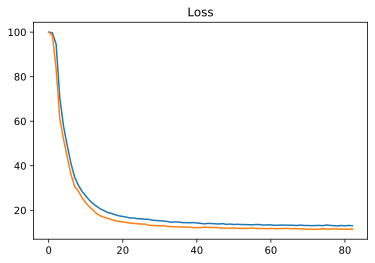

In [67]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [68]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_mlp_nlp.hdf5')

In [69]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

TEST mape: 11.61%


In [70]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2[:,0]
sample_submission.to_csv('nn20_submission10.csv', index=False)

Идеи для улучшения NLP части:
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например, сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста

# Model 5: Добавляем картинки

### Data

In [71]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

KeyError: 'sell_id'

<Figure size 864x576 with 0 Axes>

In [72]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5679, 240, 320, 3) dtype uint8
images shape (1003, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


### albumentations

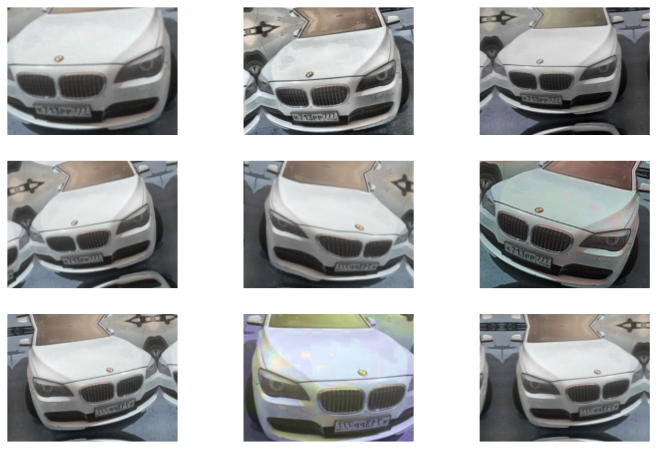

In [73]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)


#пример взят из официальной документации: https://albumentations.readthedocs.io/en/latest/examples.html
augmentation = Compose([
    HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.3),
    HueSaturationValue(p=0.3),
], p=1)

#пример
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

## tf.data.Dataset
Если все изображения мы будем хранить в памяти, то может возникнуть проблема ее нехватки. Не храните все изображения в памяти целиком!

Метод .fit() модели keras может принимать либо данные в виде массивов или тензоров, либо разного рода итераторы, из которых наиболее современным и гибким является [tf.data.Dataset](https://www.tensorflow.org/guide/data). Он представляет собой конвейер, то есть мы указываем, откуда берем данные и какую цепочку преобразований с ними выполняем. Далее мы будем работать с tf.data.Dataset.

Dataset хранит информацию о конечном или бесконечном наборе кортежей (tuple) с данными и может возвращать эти наборы по очереди. Например, данными могут быть пары (input, target) для обучения нейросети. С данными можно осуществлять преобразования, которые осуществляются по мере необходимости ([lazy evaluation](https://ru.wikipedia.org/wiki/%D0%9B%D0%B5%D0%BD%D0%B8%D0%B2%D1%8B%D0%B5_%D0%B2%D1%8B%D1%87%D0%B8%D1%81%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F)).

`tf.data.Dataset.from_tensor_slices(data)` - создает датасет из данных, которые представляют собой либо массив, либо кортеж из массивов. Деление осуществляется по первому индексу каждого массива. Например, если `data = (np.zeros((128, 256, 256)), np.zeros(128))`, то датасет будет содержать 128 элементов, каждый из которых содержит один массив 256x256 и одно число.

`dataset2 = dataset1.map(func)` - применение функции к датасету; функция должна принимать столько аргументов, каков размер кортежа в датасете 1 и возвращать столько, сколько нужно иметь в датасете 2. Пусть, например, датасет содержит изображения и метки, а нам нужно создать датасет только из изображений, тогда мы напишем так: `dataset2 = dataset.map(lambda img, label: img)`.

`dataset2 = dataset1.batch(8)` - группировка по батчам; если датасет 2 должен вернуть один элемент, то он берет из датасета 1 восемь элементов, склеивает их (нулевой индекс результата - номер элемента) и возвращает.

`dataset.__iter__()` - превращение датасета в итератор, из которого можно получать элементы методом `.__next__()`. Итератор, в отличие от самого датасета, хранит позицию текущего элемента. Можно также перебирать датасет циклом for.

`dataset2 = dataset1.repeat(X)` - датасет 2 будет повторять датасет 1 X раз.

Если нам нужно взять из датасета 1000 элементов и использовать их как тестовые, а остальные как обучающие, то мы напишем так:

`test_dataset = dataset.take(1000)
train_dataset = dataset.skip(1000)`

Датасет по сути неизменен: такие операции, как map, batch, repeat, take, skip никак не затрагивают оригинальный датасет. Если датасет хранит элементы [1, 2, 3], то выполнив 3 раза подряд функцию dataset.take(1) мы получим 3 новых датасета, каждый из которых вернет число 1. Если же мы выполним функцию dataset.skip(1), мы получим датасет, возвращающий числа [2, 3], но исходный датасет все равно будет возвращать [1, 2, 3] каждый раз, когда мы его перебираем.

tf.Dataset всегда выполняется в graph-режиме (в противоположность eager-режиму), поэтому либо преобразования (`.map()`) должны содержать только tensorflow-функции, либо мы должны использовать tf.py_function в качестве обертки для функций, вызываемых в `.map()`. Подробнее можно прочитать [здесь](https://www.tensorflow.org/guide/data#applying_arbitrary_python_logic).

In [74]:
# NLP part
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

In [75]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
  return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data.description.iloc[X_train.index], y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data.description.iloc[X_test.index], y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data.description.iloc[X_sub.index], y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

### Строим сверточную сеть для анализа изображений без "головы"

In [76]:
#нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8

efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

43941888/43941136 [==============================] - 3s 0us/step


In [77]:
#строим нейросеть для анализа табличных данных

tabular_model = Sequential([
    L.Input(shape = X.shape[1]),
    L.Dense(512, activation = 'relu'),
    L.Dropout(0.8),
    L.Dense(256, activation = 'relu'),
    L.Dropout(0.4),
    ])

In [78]:
# NLP
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.LSTM(128),
    L.Dropout(0.25),
    L.Dense(64),
    ])

In [79]:
#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 240, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 320, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 321, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [80]:
optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [81]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [82]:
history = model.fit(train_dataset.batch(30),
                    epochs=100,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

Epoch 1/100
190/190 [==============================] - 138s 725ms/step - loss: 50.7773 - MAPE: 50.7773 - val_loss: 68.6085 - val_MAPE: 68.6085
Epoch 2/100
190/190 [==============================] - 133s 701ms/step - loss: 22.1165 - MAPE: 22.1165 - val_loss: 16.7547 - val_MAPE: 16.7547
Epoch 3/100
190/190 [==============================] - 134s 707ms/step - loss: 18.7982 - MAPE: 18.7982 - val_loss: 241.2753 - val_MAPE: 241.2753
Epoch 4/100
190/190 [==============================] - 133s 699ms/step - loss: 17.1806 - MAPE: 17.1806 - val_loss: 13.8055 - val_MAPE: 13.8055
Epoch 5/100
190/190 [==============================] - 136s 714ms/step - loss: 16.2133 - MAPE: 16.2133 - val_loss: 13.8728 - val_MAPE: 13.8728
Epoch 6/100
190/190 [==============================] - 136s 716ms/step - loss: 15.5862 - MAPE: 15.5862 - val_loss: 13.0732 - val_MAPE: 13.0732
Epoch 7/100
190/190 [==============================] - 134s 704ms/step - loss: 15.1775 - MAPE: 15.1775 - val_loss: 12.8751 - val_MAPE: 12.87

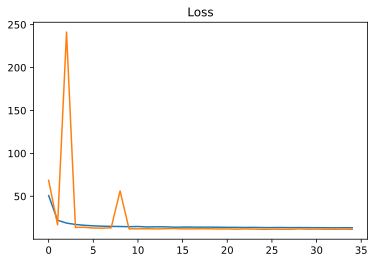

In [83]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [84]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final.hdf5')

In [85]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

TEST mape: 11.53%


In [86]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_nn3[:,0]
sample_submission.to_csv('nn30_submission10.csv', index=False)


#### Общие рекомендации:
* Попробовать разные архитектуры
* Провести более детальный анализ результатов
* Попробовать различные подходы в управление LR и оптимизаторы
* Поработать с таргетом
* Использовать Fine-tuning

#### Tabular
* В нейросеть желательно подавать данные с распределением, близким к нормальному, поэтому от некоторых числовых признаков имеет смысл взять логарифм перед нормализацией. Пример:
`modelDateNorm = np.log(2020 - data['modelDate'])`
Статья по теме: https://habr.com/ru/company/ods/blog/325422

* Извлечение числовых значений из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений.

* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'). Можно удалить эти данные. Затем можно еще сильнее сократить размерность, например выделив наличие xDrive в качестве отдельного признака.

* Поработать над Feature engineering



#### NLP
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста



#### CV
* Попробовать различные аугментации
* Fine-tuning

# Blend

In [87]:
blend_predict = (test_predict_catboost + test_predict_nn3[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 11.17%


In [88]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn3[:,0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend1_submission10.csv', index=False)

# Model Bonus: проброс признака

In [89]:
# MLP
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

In [90]:
# FEATURE Input
# Iput
productiondate = L.Input(shape=[1], name="productiondate")
# Embeddings layers
emb_productiondate = L.Embedding(len(X.productionDate.unique().tolist())+1, 20)(productiondate)
f_productiondate = L.Flatten()(emb_productiondate)

In [91]:
combinedInput = L.concatenate([model_mlp.output, f_productiondate,])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_mlp.input, productiondate], outputs=head)

In [92]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_13_input (InputLayer)     [(None, 421)]        0                                            
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 512)          216064      dense_13_input[0][0]             
__________________________________________________________________________________________________
dropout_11 (Dropout)            (None, 512)          0           dense_13[0][0]                   
__________________________________________________________________________________________________
productiondate (InputLayer)     [(None, 1)]          0                                            
_______________________________________________________________________________________

In [93]:
optimizer = tf.keras.optimizers.Adam(0.008)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [94]:
history = model.fit([X_train, X_train.productionDate.values], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([X_test, X_test.productionDate.values], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500


InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument:  indices[0,0] = -1 is not in [0, 39)
	 [[node functional_5/embedding_2/embedding_lookup (defined at <ipython-input-94-7ef152d9d1ac>:5) ]]
  (1) Invalid argument:  indices[0,0] = -1 is not in [0, 39)
	 [[node functional_5/embedding_2/embedding_lookup (defined at <ipython-input-94-7ef152d9d1ac>:5) ]]
	 [[Adam/Adam/update_4/AssignSubVariableOp/_39]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_1150941]

Errors may have originated from an input operation.
Input Source operations connected to node functional_5/embedding_2/embedding_lookup:
 functional_5/embedding_2/embedding_lookup/1150612 (defined at /opt/conda/lib/python3.7/contextlib.py:112)

Input Source operations connected to node functional_5/embedding_2/embedding_lookup:
 functional_5/embedding_2/embedding_lookup/1150612 (defined at /opt/conda/lib/python3.7/contextlib.py:112)

Function call stack:
train_function -> train_function


In [95]:
model.load_weights('../working/best_model.hdf5')
test_predict_nn_bonus = model.predict([X_test, X_test.productionDate.values])
print(f"TEST mape: {(mape(y_test, test_predict_nn_bonus[:,0]))*100:0.2f}%")

ValueError: You are trying to load a weight file containing 217 layers into a model with 5 layers.

In [96]:
train_predict_nn_bonus = model.predict([X_sub, X_sub.productionDate.values])
sample_submission['price'] = train_predict_nn_bonus
sample_submission.to_csv('train_predict_nn_bonus.csv', index=False)


InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument:  indices[4,0] = -1 is not in [0, 39)
	 [[node functional_5/embedding_2/embedding_lookup (defined at <ipython-input-96-3761f4998611>:1) ]]
  (1) Invalid argument:  indices[4,0] = -1 is not in [0, 39)
	 [[node functional_5/embedding_2/embedding_lookup (defined at <ipython-input-96-3761f4998611>:1) ]]
	 [[functional_5/embedding_2/embedding_lookup/_8]]
0 successful operations.
0 derived errors ignored. [Op:__inference_predict_function_1151054]

Errors may have originated from an input operation.
Input Source operations connected to node functional_5/embedding_2/embedding_lookup:
 functional_5/embedding_2/embedding_lookup/1151021 (defined at /opt/conda/lib/python3.7/contextlib.py:112)

Input Source operations connected to node functional_5/embedding_2/embedding_lookup:
 functional_5/embedding_2/embedding_lookup/1151021 (defined at /opt/conda/lib/python3.7/contextlib.py:112)

Function call stack:
predict_function -> predict_function


In [97]:
# 